In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pyplot
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler

### Linear Reggression

In [4]:
cycles_df = pd.read_csv("Cleaned-Data/cleaned-physiological-cycles.csv")
cycles_df.head()

,Cycle start time,Cycle end time,Cycle timezone,Recovery score %,Resting heart rate (bpm),Heart rate variability (ms),Day Strain,Energy burned (cal),Max HR (bpm),Average HR (bpm),...,Deep (SWS) duration (min),REM duration (min),Awake duration (min),Sleep need (min),Sleep debt (min),Sleep efficiency %,Sleep consistency %,Recovery category,day_of_week,Day of the week
0,2021-10-16 22:13:29,2021-10-17 23:26:57,UTC-04:00,58.0,37.0,69.0,16.3,3257.0,156.0,64.0,...,87.0,45.0,99.0,684.0,134.0,79.0,76.0,1,Saturday,Saturday
1,2021-10-15 23:10:05,2021-10-16 22:13:29,UTC-04:00,25.0,36.0,46.0,19.8,3607.0,195.0,70.0,...,65.0,31.0,149.0,654.0,117.0,66.0,77.0,0,Friday,Friday
2,2021-10-14 23:51:49,2021-10-15 23:10:05,UTC-04:00,45.0,38.0,66.0,17.9,3611.0,178.0,70.0,...,97.0,91.0,75.0,663.0,115.0,84.0,75.0,1,Thursday,Thursday
3,2021-10-13 23:00:18,2021-10-14 23:51:49,UTC-04:00,18.0,37.0,45.0,19.5,4247.0,178.0,73.0,...,82.0,11.0,115.0,679.0,139.0,75.0,87.0,0,Wednesday,Wednesday
4,2021-10-13 00:56:19,2021-10-13 23:00:18,UTC-04:00,44.0,37.0,73.0,18.3,3380.0,189.0,70.0,...,40.0,27.0,67.0,656.0,112.0,80.0,77.0,1,Wednesday,Wednesday


In [5]:
cycles_df.drop(['Cycle start time', 'Cycle end time', 'Cycle timezone', 'Day of the week', 'day_of_week'], axis=1, inplace=True)

In [6]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(cycles_df.drop(['Recovery score %', 'Recovery category'], axis=1), cycles_df['Recovery score %'], test_size=.2) #using .3 because the original whoop algo uses a months worth of data to start to customize the algorithm 

In [7]:
lin_reg = LinearRegression()
params_grid = {
    'fit_intercept' : [True, False],
    'positive' : [True, False]
}

grid_search = GridSearchCV(estimator=lin_reg, param_grid=params_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_reg, y_train_reg)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'fit_intercept': False, 'positive': False}


In [8]:
best_linear_reg = grid_search.best_estimator_
test_predictions = best_linear_reg.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, test_predictions)
mse = mean_squared_error(y_test_reg, test_predictions)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 7.216657965250355
MSE: 80.28710952436843
RMSE: 8.960307445861913


### Learning Curve

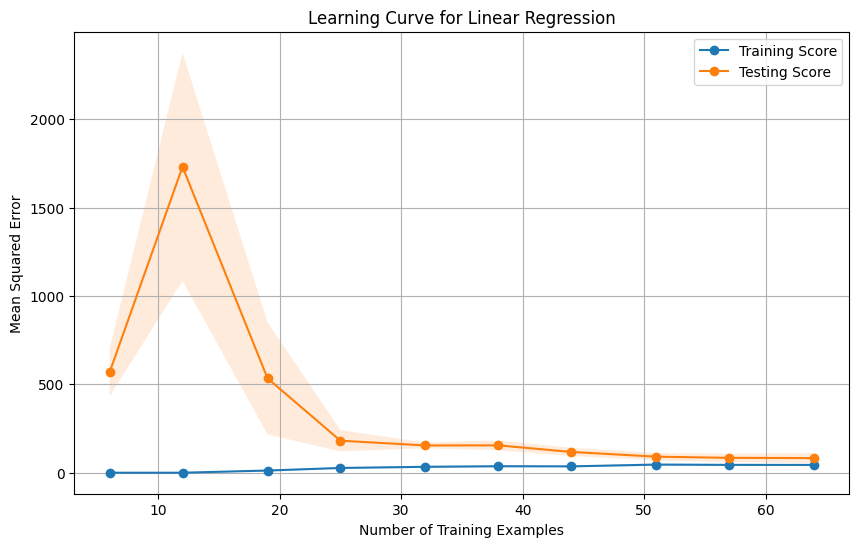

In [9]:
train_sizes = np.linspace(0.1, 1.0, 10)  # 10 different training set sizes from 10% to 100%
train_sizes, train_scores, test_scores = learning_curve(
    best_linear_reg, X_train_reg, y_train_reg, train_sizes=train_sizes, cv=5, scoring='neg_mean_squared_error'
)

# Convert negative mean squared error scores to positive
train_scores = -train_scores
test_scores = -test_scores


# Calculate the mean and standard deviation of training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.plot(train_sizes, test_mean, label='Testing Score', marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)
plt.xlabel('Number of Training Examples')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve for Linear Regression')
plt.legend()
plt.grid()
plt.show()

It looks like the best linear reggresion model I was making is overfitting. Maybe I can try to use regularization techniques.

### Decision Tree Reggressor

Using Pre-prunning techniques by changing the hyperparamters to not allow the model to overfit from the start

In [10]:
tree_reg = DecisionTreeRegressor()
params_grid = {
    'max_depth': [None, 10, 20, 30],  # Vary the maximum depth of the tree
    'min_samples_leaf': [1, 2, 4, 8],  # Vary the minimum number of samples in a leaf node
    'min_samples_split': [2, 5, 10, 20]  # Vary the minimum number of samples required to split an internal node
}

grid_search = GridSearchCV(estimator=tree_reg, param_grid=params_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_reg, y_train_reg)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [11]:
best_tree_reg = grid_search.best_estimator_
test_predictions = best_tree_reg.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, test_predictions)
mse = mean_squared_error(y_test_reg, test_predictions)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 7.253968253968255
MSE: 76.48941798941799
RMSE: 8.745822888065936


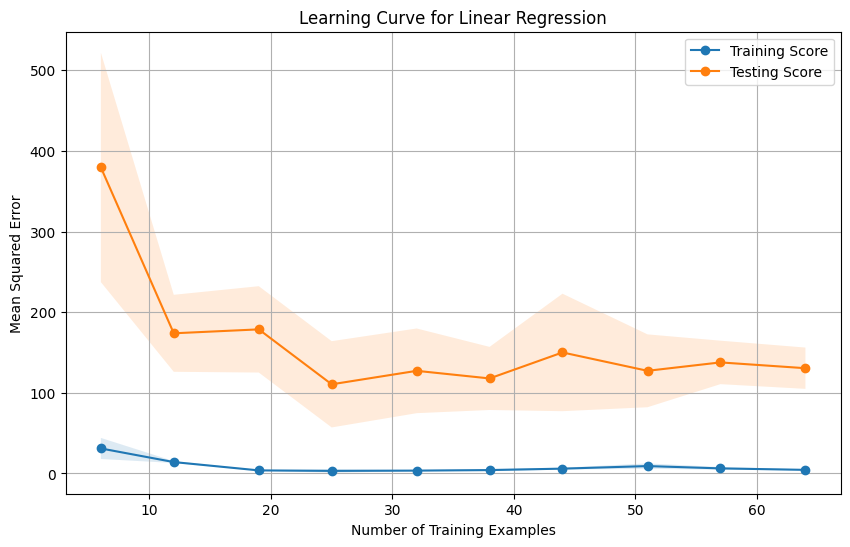

In [12]:
train_sizes = np.linspace(0.1, 1.0, 10)  # 10 different training set sizes from 10% to 100%
train_sizes, train_scores, test_scores = learning_curve(
    best_tree_reg, X_train_reg, y_train_reg, train_sizes=train_sizes, cv=5, scoring='neg_mean_squared_error'
)

# Convert negative mean squared error scores to positive
train_scores = -train_scores
test_scores = -test_scores


# Calculate the mean and standard deviation of training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.plot(train_sizes, test_mean, label='Testing Score', marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)
plt.xlabel('Number of Training Examples')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve for Linear Regression')
plt.legend()
plt.grid()
plt.show()

## Analysis of Results

In [13]:
from IPython.display import Image
import graphviz
from sklearn.tree import export_graphviz


In [19]:


from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    best_tree_reg, 
    out_file = "tree.dot", 
    feature_names = ['Resting heart rate (bpm)',
       'Heart rate variability (ms)', 'Day Strain', 'Energy burned (cal)',
       'Max HR (bpm)', 'Average HR (bpm)', 'Sleep performance %',
       'Respiratory rate (rpm)', 'Asleep duration (min)',
       'In bed duration (min)', 'Light sleep duration (min)',
       'Deep (SWS) duration (min)', 'REM duration (min)',
       'Awake duration (min)', 'Sleep need (min)', 'Sleep debt (min)',
       'Sleep efficiency %', 'Sleep consistency %'],
    class_names = ['Recovery score %'], 
    rounded = True, 
    filled = True 
)

In [20]:
graph = graphviz.Source(dot_data)

# Render the decision tree in the notebook
Image(graph.render(format='png'))

AttributeError: 'NoneType' object has no attribute 'splitlines'